<a href="https://colab.research.google.com/github/worsrp/K-pop-Female-Idol-Faces-Classification/blob/main/Inception_resnet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation
connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing


In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import os

def extract_face(filename, size):
    # load image from file
    required_size=(size, size)
    image = Image.open(filename)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def load_face(dir, require_size):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path, require_size)
        faces.append(face)
    return faces

def extract_dataset(dir, require_size):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path, require_size)
        labels = [subdir for i in range(len(faces))]
        # print progress
        print("loaded samples for class: %s" % subdir) 
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

def load_dataset(require_size) :
  # load train dataset
  train_x, train_y = extract_dataset('/content/drive/MyDrive/dataset/KID-F/train/', require_size)
  # load test dataset
  test_x, test_y = extract_dataset('/content/drive/MyDrive/dataset/KID-F/test/', require_size)

  train_x = np.array(train_x)
  train_y = np.array(train_y)
  test_x = np.array(test_x)
  test_y = np.array(test_y)
  train_x = train_x.astype('float32')
  test_x = test_x.astype('float32')

  train_x /= 255
  test_x /= 255

  return train_x, train_y, test_x, test_y

def create_one_hot(train_y,test_y):
  total_label = np.array(list(set(train_y)))
  train_mapping = np.array(train_y)
  test_mapping = np.array(test_y)

  # map each label to an integer
  mapping = {}
  for i in range(len(total_label)):
    mapping[total_label[i]] = i

  # integer representation
  for i in range(len(train_y)):
    train_mapping[i] = mapping[train_mapping[i]]

  for i in range(len(test_y)):
    test_mapping[i] = mapping[test_mapping[i]]

  one_hot_train = to_categorical(train_mapping, num_classes=55)
  one_hot_test = to_categorical(test_mapping, num_classes=55)

  return one_hot_train, one_hot_test, total_label

def create_dataset(require_size):
  train_x, train_y, test_x, test_y = load_dataset(require_size)
  one_hot_train, one_hot_test, total_label = create_one_hot(train_y,test_y)

  # split training set and validation set
  train_x, validate_x, one_hot_train, one_hot_validate = train_test_split(np.array(train_x), np.array(one_hot_train), test_size=0.1, shuffle= True)
  
  return train_x, validate_x, test_x, test_y, one_hot_train, one_hot_validate, one_hot_test, total_label     

In [3]:
train_x, validate_x, test_x, test_y, one_hot_train, one_hot_validate, one_hot_test, total_label = create_dataset(160)

loaded samples for class: minyoung
loaded samples for class: jihyo
loaded samples for class: wonyoung
loaded samples for class: rei
loaded samples for class: choilee
loaded samples for class: jeongyeon
loaded samples for class: kimchaewon
loaded samples for class: mina
loaded samples for class: joyuri
loaded samples for class: jisoo
loaded samples for class: sunny
loaded samples for class: bravegirls_yuna
loaded samples for class: le
loaded samples for class: jennie
loaded samples for class: kwoneunbi
loaded samples for class: nayeon
loaded samples for class: kanghyewon
loaded samples for class: giselle
loaded samples for class: hongeunchae
loaded samples for class: hondahitomi
loaded samples for class: yujin
loaded samples for class: bravegirls_eunji
loaded samples for class: kimminju
loaded samples for class: bravegirls_yujeong
loaded samples for class: sana
loaded samples for class: ningning
loaded samples for class: yeri
loaded samples for class: hyolin
loaded samples for class: ro

# Training Phase


### initialize hyperparameter

In [4]:
import keras
import tensorflow as tf
from keras.models import load_model

NUM_CLASSES = 55
LEARN_RATE = 0.01
MOMENTUM = 0.9
BATCH_SIZE = 128
EPOCHS = 10

### load pretrained model

In [5]:
base_model = load_model('/content/drive/MyDrive/NNmodel/inception.h5')

### initialize neural network

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

inception_resnet = keras.Sequential([
        base_model,
        
        keras.layers.Dropout(0.20),
        keras.layers.Flatten(),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [7]:
inception_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v1 (Functi  (None, 128)              22808144  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 55)                7095      
                                                                 
Total params: 22,815,239
Trainable params: 22,786,407
Non-trainable params: 28,832
_________________________________________________________________


### set up optimizer and loss function

In [8]:
sgd_opt = keras.optimizers.SGD(learning_rate=LEARN_RATE, momentum=MOMENTUM)
cce_loss = keras.losses.categorical_crossentropy

### train model

In [9]:
inception_resnet.compile(optimizer=sgd_opt, loss=cce_loss, metrics=['accuracy'])

In [10]:
train_history = inception_resnet.fit(train_x, one_hot_train ,batch_size=BATCH_SIZE, epochs=EPOCHS ,validation_data=(validate_x, one_hot_validate))

Epoch 1/10
40/40 [==============================] - 45s 618ms/step - loss: 1.7359 - accuracy: 0.6172 - val_loss: 1.1083 - val_accuracy: 0.7482
Epoch 2/10
40/40 [==============================] - 21s 516ms/step - loss: 0.3957 - accuracy: 0.9066 - val_loss: 0.8391 - val_accuracy: 0.7946
Epoch 3/10
40/40 [==============================] - 22s 543ms/step - loss: 0.2149 - accuracy: 0.9551 - val_loss: 0.5830 - val_accuracy: 0.8696
Epoch 4/10
40/40 [==============================] - 21s 538ms/step - loss: 0.1239 - accuracy: 0.9748 - val_loss: 0.4861 - val_accuracy: 0.8786
Epoch 5/10
40/40 [==============================] - 21s 531ms/step - loss: 0.0803 - accuracy: 0.9861 - val_loss: 0.4206 - val_accuracy: 0.8946
Epoch 6/10
40/40 [==============================] - 21s 531ms/step - loss: 0.0562 - accuracy: 0.9911 - val_loss: 0.3699 - val_accuracy: 0.9143
Epoch 7/10
40/40 [==============================] - 21s 532ms/step - loss: 0.0426 - accuracy: 0.9940 - val_loss: 0.3408 - val_accuracy: 0.9179

### plot result

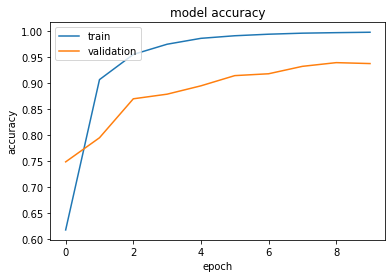

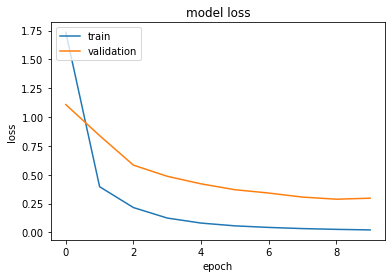

train acc_max: 0.9978135824203491
val acc_max: 0.9392856955528259
train loss_min: 0.02096433937549591
val loss_min: 0.28749340772628784


In [11]:
import matplotlib.pyplot as plt
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print("train acc_max:",max(train_history.history['accuracy']))
print("val acc_max:",max(train_history.history['val_accuracy']))
print("train loss_min:",min(train_history.history['loss']))
print("val loss_min:",min(train_history.history['val_loss']))


#Testing Phase

In [23]:
import random

correct = 0
test_len = len(test_x)
true_prediction = []
true_img = []
false_prediction = []
false_img = []

for i in range(test_len):
  img = test_x[i]
  expectation = test_y[i]
  p_img = np.reshape(img ,(1,160,160,3))

  prediction = inception_resnet.predict(p_img)
  label = total_label
  result = label[np.argmax(prediction)]

  if(result==expectation):
    correct += 1
  else:
    idx_arr = np.where(test_y == result)
    rand = random.randint(0, len(idx_arr))
    if(len(idx_arr[0])!=0):
      idx = idx_arr[0][rand]
      
      true_prediction.append(expectation)
      true_img.append(test_x[i])

      false_prediction.append(result)
      false_img.append(test_x[idx])

acc = correct/test_len

1/1 [==============================] - 0s 29ms/step


In [24]:
print('Testing accuracy: ', acc)

Testing accuracy:  0.9454545454545454


### Model Prediction Examples

1/1 [==============================] - 0s 31ms/step


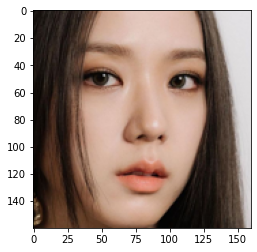

[[4.1897576e-05 5.2923406e-05 1.2700296e-05 1.3092342e-05 3.2045515e-04
  8.4350850e-06 4.5460715e-06 9.9719584e-01 2.4230747e-05 1.4493519e-05
  6.4272726e-06 6.7250812e-06 8.9307650e-06 1.0578848e-05 2.4699330e-05
  2.7585810e-04 7.2419407e-06 4.0786243e-05 7.0502047e-06 1.5391515e-05
  1.6891672e-05 3.7051464e-05 1.0120934e-05 1.1118121e-05 6.9980932e-05
  5.3861513e-05 9.8869316e-07 8.6080663e-06 7.1775116e-07 7.1778402e-07
  1.1146712e-05 4.2459742e-05 5.2378487e-06 2.9070893e-06 7.4444197e-06
  1.9971607e-05 4.0355454e-07 7.7102695e-06 5.1421612e-06 7.4358513e-07
  5.3852575e-05 5.0050394e-06 5.6644749e-06 3.7733807e-05 3.8009672e-05
  9.6822064e-04 3.1712732e-06 1.6432583e-05 1.1648502e-05 4.1160558e-04
  2.7406071e-05 2.6867340e-08 9.6862332e-06 3.5754538e-06 2.4629617e-06]]
expectation: jisoo
prediction: jisoo


In [19]:
rand = random.randint(0, len(test_x))

img = test_x[rand]
expectation = test_y[rand]
p_img = np.reshape(img ,(1,160,160,3))

result = inception_resnet.predict(p_img)
label = total_label
prediction = label[np.argmax(result)]

plt.imshow(img)
plt.show()
print(result)
print('expectation: '+expectation)
print('prediction: '+prediction)

##False Prediction Examples

False prediction example 1


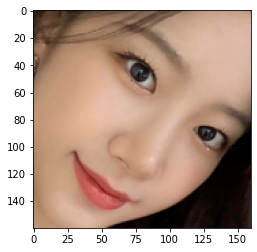

expectation: kazuha


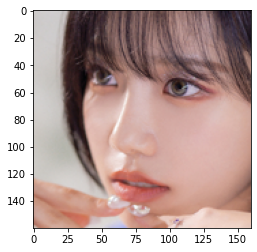

prediction: joyuri
False prediction example 2


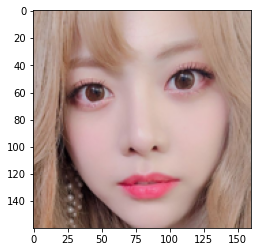

expectation: bravegirls_eunji


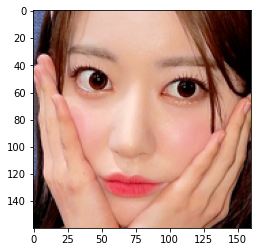

prediction: sakura
False prediction example 3


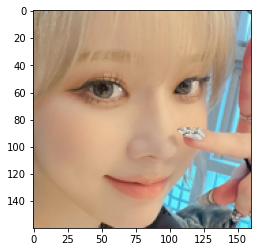

expectation: yujin


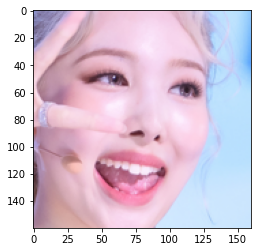

prediction: nayeon


In [22]:
for i in range (3):
  rand = random.randint(0, len(false_prediction))

  expectation = true_prediction[rand]
  prediction = false_prediction[rand]

  print('False prediction example',i+1)
  plt.imshow(true_img[rand])
  plt.show()
  print('expectation: '+expectation)
  plt.imshow(false_img[rand])
  plt.show()
  print('prediction: '+prediction)